# Exploratory Data Analysis (EDA) on AudioSet from Google

Author : Ling Thang
Date Created : April 19 2025

**see milestone update at the end of the notebook**

# Retrieve the metadata 

### Segment files

```bash
curl -O https://storage.googleapis.com/audioset/balanced_train_segments.csv

curl -O https://storage.googleapis.com/audioset/unbalanced_train_segments.csv

curl -O https://storage.googleapis.com/audioset/eval_segments.csv
```

### Class map & ontology

```bash
curl -O https://storage.googleapis.com/audioset/class_labels_indices.csv

curl -O https://raw.githubusercontent.com/audioset/ontology/master/ontology.json
```

________________________________________________________________________________________

# Isolate instrumental music

In [10]:
import pandas as pd, json, re

labels = pd.read_csv("data/class_labels_indices.csv")

print(labels.head())


   index        mid                   display_name
0      0   /m/09x0r                         Speech
1      1  /m/05zppz      Male speech, man speaking
2      2   /m/02zsn  Female speech, woman speaking
3      3   /m/0ytgt     Child speech, kid speaking
4      4  /m/01h8n0                   Conversation


In [24]:
with open("data/ontology.json") as f:
    ont = {n['id']: n for n in json.load(f)}

# find every node whose ancestor path includes the Musical‑instrument MID
def descendants(mid, ont):
    """Return *all* descendant MIDs of `mid` (recursive)."""
    kids = ont[mid].get('child_ids', [])
    return set(kids).union(*(descendants(k, ont) for k in kids))

instrument_mid = next(k for k,v in ont.items() if v['name'] == 'Musical instrument')
instrument_mids = descendants(instrument_mid, ont) | {instrument_mid}

instr_df = labels[labels.mid.isin(instrument_mids)]
print(len(instr_df))          # ≈ 40 direct/indirect instrument classes

80


In [25]:
print(instr_df.head())

     index        mid               display_name
28      28  /m/0l14jd                      Choir
92      92  /m/0239kh                    Cowbell
138    138   /m/04szw         Musical instrument
139    139  /m/0fx80y  Plucked string instrument
140    140   /m/0342h                     Guitar


In [26]:
seg = pd.read_csv(
    "data/balanced_train_segments.csv",
    comment='#',
    names=['ytid', 'start', 'end', 'labels'],
    quotechar='"',
    skipinitialspace=True  
)
seg = seg.assign(label_list = seg.labels.str.split(',')) \
         .explode('label_list') \
         .query('label_list in @instr_df.mid')

In [31]:
seg.head(10)

,ytid,start,end,labels,label_list
11,-0SdAVK79lg,30.0,40.0,"/m/0155w,/m/01lyv,/m/0342h,/m/042v_gx,/m/04rlf...",/m/0342h
11,-0SdAVK79lg,30.0,40.0,"/m/0155w,/m/01lyv,/m/0342h,/m/042v_gx,/m/04rlf...",/m/042v_gx
11,-0SdAVK79lg,30.0,40.0,"/m/0155w,/m/01lyv,/m/0342h,/m/042v_gx,/m/04rlf...",/m/04szw
11,-0SdAVK79lg,30.0,40.0,"/m/0155w,/m/01lyv,/m/0342h,/m/042v_gx,/m/04rlf...",/m/07s0s5r
11,-0SdAVK79lg,30.0,40.0,"/m/0155w,/m/01lyv,/m/0342h,/m/042v_gx,/m/04rlf...",/m/0fx80y
12,-0Vl4HyWRk8,410.0,420.0,"/m/085jw,/m/0l14l2",/m/085jw
12,-0Vl4HyWRk8,410.0,420.0,"/m/085jw,/m/0l14l2",/m/0l14l2
26,-38Qgsbh7NQ,100.0,110.0,"/m/013y1f,/m/03xq_f",/m/013y1f
26,-38Qgsbh7NQ,100.0,110.0,"/m/013y1f,/m/03xq_f",/m/03xq_f
31,-3pPrlCm6gg,30.0,40.0,/m/01wy6,/m/01wy6


In [32]:
print(seg.label_list.nunique())      # dozens, not 1
print(seg.label_list.value_counts().head())

80
label_list
/m/04szw     532
/m/0342h     350
/m/0fx80y    302
/m/0l14md    263
/m/085jw     262
Name: count, dtype: int64


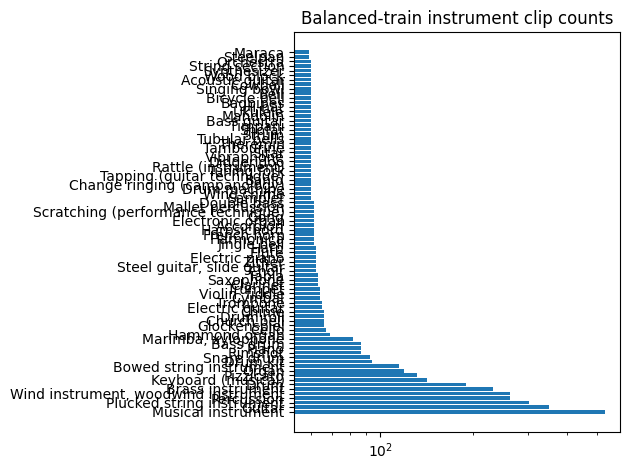

In [35]:
import matplotlib.pyplot as plt, numpy as np

counts = seg['label_list'].value_counts()
plt.barh(counts.index.map(instr_df.set_index('mid').display_name),
         counts.values)
plt.xscale('log'); plt.title('Balanced‑train instrument clip counts')
plt.tight_layout()

In [40]:
import warnings, librosa, librosa.display
warnings.filterwarnings("ignore", category=UserWarning, module="librosa")  # hide PySoundFile/audioread chatter

y, sr = librosa.load("example.wav", sr=16_000)
librosa.display.waveshow(y, sr=sr)
librosa.display.specshow(
        librosa.power_to_db(librosa.feature.melspectrogram(y, sr=sr, n_mels=64)),
        sr=sr, hop_length=512, x_axis='time', y_axis='mel')

/var/folders/22/hdrqs83s5z94vp_xg1v9l_180000gn/T/ipykernel_88426/1870612327.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load("example.wav", sr=16_000)
/opt/homebrew/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'example.wav'

# Project milestone update 4/19/2025
- 4/19/2025 : 
    - Completed the EDA on AudioSet dataset
    - Isolated instrumental music from the dataset
    - Visualized the distribution of instrumental music in the dataset

- Blockers : 
    - running into issues with the the audio files and librosa library
    - need to find a way to isolate instrumental music from the dataset

- Next steps : 
    - Continue working on the EDA and visualization of the dataset
    - Look into using other libraries for audio processing
    - Continue to work on the project and update the milestone as needed

Working with the AudioSet dataset is proving to be more challenging than I had anticipated. There is limited documentation on the dataset since it is still fairly new to the community. I used ChatGPT and Gemini mainly to learn more about the dataset and how to work with it. Gemini was able to provide me with the latest information on the dataset and chat was able to help me the code for EDA. I am still running into issues with the dataset. I will have to continue looking into the dataset and seeing if there is a library that I can use to help me with the audio processing. I will also need to look into the dataset and see if there is a way to isolate instrumental music from the dataset. I will continue to work on the project and update the milestone as needed.

biggest challenge so far is working with the new format with audio files and learning new libraries. Regardless of the challenges that I am running into I am learning alot and excited to continue working on this project. 